In [1]:
import pathlib

import osmnx
import networkx

from clusters import Cluster, ClusterCentreStrategy
from population import PopulationGeneratorConfig, generate_data_points
from traffic import IncrementalBatchRouteAssigner
from travel import TravelGenerator
import pandas as pd
import seaborn as sns
from utils import visualize_clusters, visualize_points, visualize_paths, visualize_weighted_paths, rescale


RESOLUTION = 8


config = PopulationGeneratorConfig.from_json_file(pathlib.Path("/home/ajwo/IdeaProjects/slupsk-user-equilibrium/configs/slupsk_2004_hyperpopulated.json"))
cluster_centre_strategy = ClusterCentreStrategy.HEXAGON_CENTER
pts_by_epi = {epi.label: generate_data_points(epi) for epi in config.epicentres}
points = [point for pts in pts_by_epi.values() for point in pts]
places = [
    'Słupsk, Polska',
    'gmina Słupsk, Polska',
    'gmina Kobylnica, Polska',
]
custom_filter = '["highway"~"motorway|primary|secondary|tertiary"]'
graph = osmnx.graph.graph_from_place(places, network_type="drive", custom_filter=custom_filter)
graph = osmnx.speed.add_edge_travel_times(osmnx.add_edge_speeds(graph))
clusters = Cluster.consolidate_clusters(Cluster.clusterize_points(points, RESOLUTION, cluster_centre_strategy), graph, RESOLUTION)
travels = TravelGenerator(config).generate_travels(clusters)
assigner = IncrementalBatchRouteAssigner(h3_resolution=8, iterations_count=4, batch_size=10)

In [2]:
routes = assigner.assign_routes(travels, clusters, graph)

In [3]:
cluster_by_id = {cluster.h3_hex_id: cluster for cluster in clusters}

In [4]:
df = pd.DataFrame([
    {
        "start": start, 
        "end": end, 
        "travel_time": state.travel_time.minutes, 
        "free_flow_travel_time": state.path_data.free_flow_travel_time.minutes, 
        "capacity": state.path_data.max_capacity, 
        "volume": len(state.current_volume),
        "path": state.path_data.path,
    } for (start, end, state) in assigner.graph.edges.data("state")
])

df["traffic_slowdown"] = df["travel_time"] - df["free_flow_travel_time"]
df

,start,end,travel_time,free_flow_travel_time,capacity,volume,path,traffic_slowdown
0,881f0d4545fffff,881f0d4547fffff,21.869924,2.202417,2200,6111,"[1161693605, 1849311157, 2325837782, 295764688...",1.966751e+01
1,881f0d4545fffff,881f0d456bfffff,3.321521,2.395925,2200,2787,"[1161693605, 1849311157, 2325837782, 295764688...",9.255963e-01
2,881f0d4545fffff,881f0d454dfffff,1.552479,1.552479,2200,13,"[1161693605, 1849311157, 1849311151, 116169373...",2.839224e-10
3,881f0d4545fffff,881f0d4541fffff,20.354767,2.676816,2200,5667,"[1161693605, 1849311157, 2325837782, 295764688...",1.767795e+01
4,881f0d4545fffff,881f0d4569fffff,8.009601,1.464428,2200,5140,"[1161693605, 1161693609, 1161693612, 116169375...",6.545172e+00
...,...,...,...,...,...,...,...,...
105,881f0d4091fffff,881f0d4097fffff,4.010520,1.727804,2200,3790,"[5810491671, 3889902205, 2816986861, 378762250...",2.282716e+00
106,881f0d4091fffff,881f0d409bfffff,1.340413,0.845541,2200,3092,"[5810491671, 3889902205, 2816986861, 378758255...",4.948723e-01
107,881f0d4091fffff,881f0d4093fffff,0.436872,0.435036,2200,901,"[5810491671, 3889902205, 2816986861, 378758255...",1.835799e-03
108,881f0d40b7fffff,881f0d40b3fffff,1.278973,1.278973,4400,2,"[343506099, 1156476310, 2685985587, 1157469388]",7.993606e-15


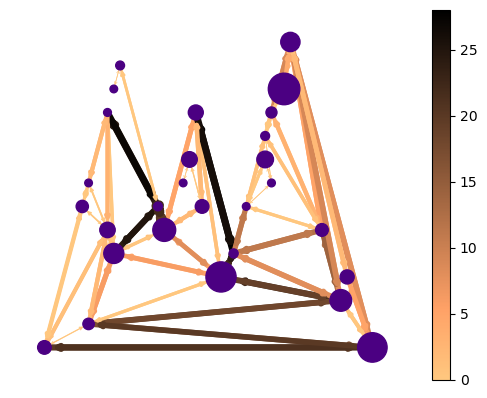

In [5]:
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

pos = nx.planar_layout(assigner.graph,)

nodelist = cluster_by_id.keys()
cluster_pops = [len(cluster.points) for cluster in cluster_by_id.values()]
node_sizes = [30 + 700*np.log(1 + (pop_count - min(cluster_pops)) / (max(cluster_pops) - min(cluster_pops)) )for pop_count in cluster_pops]

edge_volumes = [
    int(df[(df["start"] == start) & (df["end"] == end)]["volume"]) 
    for (start, end) in assigner.graph.edges
]
widths = [
    .5+10*np.log(1 + (edge_volume - min(edge_volumes)) / (max(edge_volumes) - min(edge_volumes)) )
    for edge_volume in edge_volumes
]

edge_traffic_slowdowns = [
    int(df[(df["start"] == start) & (df["end"] == end)]["traffic_slowdown"]) 
    for (start, end) in assigner.graph.edges
]
edge_colors = edge_traffic_slowdowns
cmap = plt.cm.copper_r

nodes = nx.draw_networkx_nodes(assigner.graph, pos, node_size=node_sizes, node_color="indigo")
ax = plt.gca()
edges = nx.draw_networkx_edges(
    assigner.graph,
    pos,
    ax=ax,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=5,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=widths,
)

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [6]:
cmap = plt.cm.copper_r
edge_traffic_slowdowns = [
    round(row["traffic_slowdown"])
    for _, row in df.iterrows()
]
MIN_SLOWDOWN = 0
MAX_SLOWDOWN = max(30, max(edge_traffic_slowdowns))
colors = [
    mpl.colors.rgb2hex(cmap(rescale(slowdown, old_max=MAX_SLOWDOWN, old_min=MIN_SLOWDOWN, new_max=1, new_min=0)))
    for slowdown in edge_traffic_slowdowns
]
edge_volumes = [
    round(row["volume"])
    for _, row in df.iterrows()
]
MIN_VOLUME = 0
MAX_VOLUME = max(20000, max(edge_volumes))
weights = [
    rescale(volume, old_max=MAX_VOLUME, old_min=MIN_VOLUME, new_max=10, new_min=1) 
    for volume in edge_volumes
]

In [7]:
import folium


m = folium.Map(location=[54.46270136314862, 17.019373399360482], zoom_start=13, tiles='cartodbpositron')
visualize_weighted_paths(m, graph, list(df.path), colors, weights)
visualize_clusters(m, clusters, ['green'])
visualize_points(m, [cluster.centre for cluster in clusters], ['green'])
m

In [8]:
df[(df["start"] == "881f0d4569fffff") & (df["end"] == "881f0d4545fffff")]

,start,end,travel_time,free_flow_travel_time,capacity,volume,path,traffic_slowdown
29,881f0d4569fffff,881f0d4545fffff,8.072314,1.594307,2200,5019,"[258137122, 1161674577, 258137502, 1161655143,...",6.478006


In [9]:
assigner.graph["881f0d4569fffff"]["881f0d4545fffff"]["weight"]

8.072313825637032

In [10]:
assigner.graph["881f0d4569fffff"]["881f0d456bfffff"]["weight"] + assigner.graph["881f0d456bfffff"]["881f0d4545fffff"]["weight"]

10.406487842102004

In [11]:
assigner.graph["881f0d4569fffff"]["881f0d4093fffff"]["weight"] + assigner.graph["881f0d4093fffff"]["881f0d4545fffff"]["weight"]

8.217754874374652